In [55]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Get the user_review data

data = pd.read_csv("Data/google-play-store-apps/googleplaystore_user_reviews.csv",encoding="latin1")

### EDA 

In [56]:
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [57]:
data.isnull().count()

App                       64295
Translated_Review         64295
Sentiment                 64295
Sentiment_Polarity        64295
Sentiment_Subjectivity    64295
dtype: int64

Let's get our model data, since we don't actually care about all the options above. In fact, we care about Translated_review and Sentiment. Let's also drop all the null values. 

In [58]:
data = pd.concat([data['Translated_Review'], data['Sentiment']], axis=1)
data.dropna(axis=0, inplace=True)
data.tail()

,Translated_Review,Sentiment
64222,Most ads older many agents ..not much owner po...,Positive
64223,"If photos posted portal load, fit purpose. I'm...",Positive
64226,"Dumb app, I wanted post property rent give opt...",Negative
64227,I property business got link SMS happy perform...,Positive
64230,"Useless app, I searched flats kondapur, Hydera...",Negative


In [59]:
# These are the unique values to be found in the Sentiment column. Note 
# that we'll be predicting sentiment from the contents of the review 
# column, which means sentiment is our target. 

data.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [61]:
# But to be more useful we need to give these strings integers values 
# instead, so it'll be more like a classification problem. 

data["Sentiment"] = [0 if i == "Positive" else 1 if i == "Negative" else 2 for i in data["Sentiment"]]
data["Sentiment"].unique()

array([0, 2, 1])

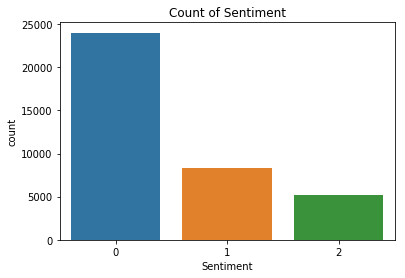

In [64]:
sns.countplot(data['Sentiment'])
plt.title("Count of Sentiment")
plt.show()

In [65]:
data["Sentiment"].value_counts()

0    23998
1     8271
2     5158
Name: Sentiment, dtype: int64

So the overwhelming majority of the reviews are positive, and we've got a good idea of what we're dealing with now. 

### Preprocessing 

In [67]:
# Before we process all the text, we'll process a single example to 
# illustrate what's happening. 

first_sample = data["Translated_Review"][9]
sample = re.sub('[^a-zA-Z]', " ", first_sample)
sample = sample.lower()

print("[{}] gets transformed into \n[{}]".format(data['Translated_Review'][9], sample))

[It helpful site ! It help foods get !] gets transformed into 
[it helpful site   it help foods get  ]


In [69]:
sample = nltk.word_tokenize(sample)
print(sample)

['it', 'helpful', 'site', 'it', 'help', 'foods', 'get']


In [73]:
sample = [word for word in sample if not word in set(stopwords.words('english'))]
print(sample)

['helpful', 'site', 'help', 'foods', 'get']


In [74]:
lemma = nltk.WordNetLemmatizer()
sample = [lemma.lemmatize(word) for word in sample]
sample = " ".join(sample)
print(sample)

helpful site help food get


In [76]:
# Now, for everything 

text_list = []
for i in data["Translated_Review"]:
    text = re.sub('[^a-zA-Z]', " ", i)
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [lemma.lemmatize(word) for word in text]
    text = " ".join(text)
    text_list.append(text)



In [77]:
print(text_list[:10])

['i like eat delicious food that s i m cooking food myself case best food help lot also best before shelf life', 'this help eating healthy exercise regular basis', 'work great especially going grocery store', 'best idea u', 'best way', 'amazing', 'looking forward app', 'it helpful site it help food get', 'good you', 'useful information the amount spelling error question validity information shared once fixed star given']


In [78]:
cou_vec = CountVectorizer(max_features = 1000)
sparse_matrix = cou_vec.fit_transform(text_list).toarray()
all_words = cou_vec.get_feature_names()
print("The 50 words we see the most: {}".format(all_words[:50]))

The 50 words we see the most: ['ability', 'able', 'about', 'absolutely', 'access', 'account', 'accurate', 'across', 'action', 'activity', 'actual', 'actually', 'ad', 'add', 'added', 'addicted', 'addicting', 'addictive', 'adding', 'advert', 'advertisement', 'after', 'again', 'age', 'ago', 'alarm', 'alert', 'all', 'allow', 'allows', 'almost', 'along', 'alot', 'already', 'also', 'although', 'always', 'am', 'amazing', 'amazon', 'amount', 'an', 'and', 'android', 'anime', 'annoying', 'another', 'answer', 'any', 'anymore']


#### Naive Bayes 

In [85]:
x = sparse_matrix
y = data.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = .2, random_state = 1)

In [87]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print("accuracy : ", nb.score(X_test, y_test))

accuracy :  0.5903018968741651


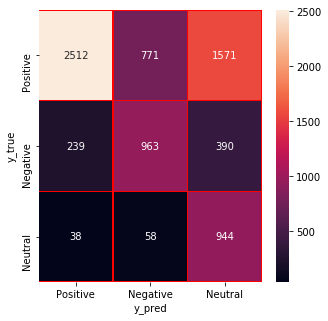

In [89]:
# We can get more granular analysis with a confusion matrix 

y_pred = nb.predict(X_test)

names = ["Positive", "Negative", "Neutral"]
cm = confusion_matrix(y_test, y_pred)

f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm, annot=True, linewidth = .5, linecolor = 'r', fmt = '.0f', ax=ax)

plt.xlabel('y_pred')
plt.ylabel('y_true')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

#### Random Forest Classifier 

In [91]:
rfc = RandomForestClassifier(n_estimators = 10, random_state = 42)
rfc.fit(X_train, y_train)
print("rfc accuracy : ", rfc.score(X_test, y_test))

rfc accuracy :  0.8936681806037937


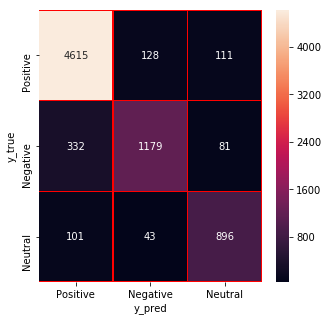

In [92]:
## Let's do the confusion matrix thing again. 

y_pred = rfc.predict(X_test)

names = ["Positive", "Negative", "Neutral"]
cm = confusion_matrix(y_test, y_pred)

f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm, annot=True, linewidth = .5, linecolor = 'r', fmt = '.0f', ax=ax)

plt.xlabel('y_pred')
plt.ylabel('y_true')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

#### Logistic Regression 

In [93]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("logreg accuracy : ", logreg.score(X_test, y_test))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logreg accuracy :  0.9010152284263959


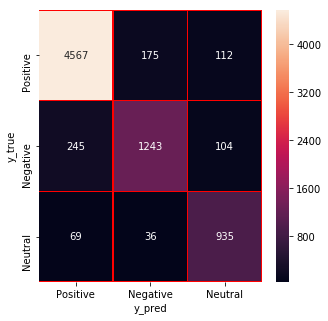

In [94]:
y_pred = logreg.predict(X_test)

names = ["Positive", "Negative", "Neutral"]
cm = confusion_matrix(y_test, y_pred)

f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm, annot=True, linewidth = .5, linecolor = 'r', fmt = '.0f', ax=ax)

plt.xlabel('y_pred')
plt.ylabel('y_true')
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()